# Portfolio Management - Solution


In [1]:
# import all libraries we'll need
import pandas as pd # For datasets
import matplotlib.pyplot as plt # For plots
import numpy as np # For numerical operations like logarithm

# Python requires to import some libraries, don't worry about these yet
from pandas_datareader import data as pdr
import datetime as dt


# Tell the application to show the plots within this webpage
%matplotlib inline

# Display only two decimals to avoid distraction
pd.set_option('display.precision',3)

# Pretty tables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



def rets2prices(r):
    prices = (1+r).cumprod() 
    prices.iloc[0,:] = 1
    return prices


def calc_returns(rets):
    log_rets = np.log(1 + rets)
# Simple addition
    cum_rets = rets.cumsum()
# Log addition
    cum_logrets = np.exp(log_rets.cumsum())-1
 # Additional types of returns
    indexed_returns = rets2prices(rets)
    money_returns = indexed_returns * 1000
       
    return log_rets,cum_rets,cum_logrets,indexed_returns,money_returns

def daily_drawdown(df):
    window = len(df)
    Roll_Max = df.rolling(window, min_periods=1).max()
    Daily_Drawdown = 100*(df-Roll_Max)/Roll_Max
    return Daily_Drawdown

def Backtest(rets):

    cols = ['Avg Returns', 'Avg Volatility', 'Sharpe Ratio', 'Max Drawdown']
    idx = rets.columns
    Stats = pd.DataFrame(columns=cols, index = idx)

    Stats['Avg Returns'] = rets.mean() * 252 * 100 
    Stats['Avg Volatility'] = rets.std() * np.sqrt(252) * 100 

    # Risk-adjusted Average Return
    Stats['Sharpe Ratio'] = np.sqrt(252) * rets.mean() / rets.std() 

    prices = rets2prices(rets)
    Daily_Drawdown = daily_drawdown(prices)
    Stats['Max Drawdown'] = Daily_Drawdown.min()
    
    return Stats,Daily_Drawdown

In [2]:
# Let's get data on 2 other stocks and on the S&P 500 index
start_date = dt.date(2000,1,1)
end_date = dt.date.today()
names = ['S&P500','Microsoft','Walmart','Amazon']
tickers = ['^GSPC','MSFT','WMT','AMZN']
stock_prices = pd.DataFrame(pdr.get_data_yahoo(tickers,start_date, end_date)['Adj Close'])
stock_prices.columns = names
stock_prices

NameError: name 'start_date' is not defined

In [3]:
InteractiveShell.ast_node_interactivity = "all"
# Read data from csv files for each stock and show a data sample


# Define stocks for study
names = ['S&P500','Microsoft','Walmart','Amazon']
tickers = ['^GSPC','MSFT','WMT','AMZN']

# Load pricing data from the selected stocks, each from one .csv file
for i in range(len(tickers)): 
    df = pd.read_csv('../data/'+tickers[i]+'.csv')
    if i <= 0:
        new_df = df[['Date','Adj Close']].copy()
        new_df.Date = pd.to_datetime(new_df.Date).copy()
        new_df = new_df.rename(columns = {'Adj Close':'S&P500'})
    else:
        new_df[tickers[i]] = df[['Adj Close']].copy()

# We store only the Adjusted Close Price and we align all timeseries
new_df = new_df.set_index(new_df.Date)  
new_df = new_df.drop('Date',axis=1)

returns = new_df.pct_change()


# Homework

Create different combinations of portfolios using these same 3 stocks.

Can you find the "optimal" portfolio?

- The optimal portfolio is the one that results in the largest Sharpe Ratio

Note: You can vary the weights any way you want, even use negative weights.

See examples below !

Only 1 restriction:
- All weights always add up to 1.0

Hint: The answer doesn't use negative weights, but you may play with them so you learn



## Special prize for the person/team (you can colaborate) who finds the largest Sharpe Ratio possible

In [4]:
# We call this one 130/30 because it is 130% "long" and 30% short - I can explain next session
portfolio = np.array([0.5, 0.8, -0.3])
print ( np.sum(portfolio) == 1 )
print ( np.sum(portfolio[portfolio>0]) <= 2.0 )
print ( np.sum(portfolio[portfolio<0]) >= -2.0 )
print ()

# We call this one ...
portfolio = np.array([1.0, 1.0, -1.0])
# Yes you guessed it: 200/100
print ( np.sum(portfolio) == 1 )
print ( np.sum(portfolio[portfolio>0]) <= 2.0 )
print ( np.sum(portfolio[portfolio<0]) >= -2.0 )
print ()

# And this one doesn't have a name but it's just another example
portfolio = np.array([0.5, 0.2, 0.3])
print ( np.sum(portfolio) == 1 )
print ( np.sum(portfolio[portfolio>0]) <= 2.0 )
print ( np.sum(portfolio[portfolio<0]) >= -2.0 )
print ()

True
True
True

True
True
True

True
True
True



## Analytical Solution

We want to maximize the Utility (benefit we get from investing). We like positive returns but we dislike variability
Therefore:

$$ Maximize \space U =  h^T * \alpha - \lambda * h^T * V * h $$

$$ subject \space to: \space h^T * 1 = 1 $$

Then, deriving with respect to variable "h" (portfolio holdings) and equallying to zero, we can obtain the maximum:

$$ \frac {\delta U }{\delta h} = \alpha - 2*\lambda*h^T*V = 0 $$

Therefore:

$$ optimal \space porfolio =  h = {V^{-1}} * \alpha $$

But since we have the restriction that the sum of all holdings should be 1.0, we divide by the sum of all h_i

$$ optimal \space porfolio =  h = \frac{{V^{-1}} * \alpha}{\alpha^T * {V^{-1}} * 1} $$

Where:

$$ \alpha^T * {V^{-1}} * 1 == \sum {h_i}  $$

Here we proxy alpha as Expected Return

In [5]:
# Try to make sure that T >> N
# How to extend the cov of F to cov of stocks

# Analytical Solution in code
cov_mat = returns[['MSFT','WMT','AMZN']].cov()
vec_one = np.matrix(np.ones(3))
inv_cov_mat = np.linalg.pinv(cov_mat)
exp_ret = np.matrix(returns[['MSFT','WMT','AMZN']].mean())
#exp_ret = np.matrix(vec_one)

# Analytical solution
h = np.array( inv_cov_mat*np.transpose(exp_ret) / (exp_ret*inv_cov_mat*np.transpose(exp_ret))  )

# Small step to convert from array to list
h = [j for i in list(h) for j in i]
print (h)

[213.89819804704098, 337.2704222993491, 649.5866549096293]


In [6]:
# Analytical solution
hq = np.array( inv_cov_mat*np.transpose(exp_ret) / (exp_ret*inv_cov_mat*np.transpose(exp_ret))  )

# Small step to convert from array to list
#hq = [j for i in list(h) for j in i]
print (hq)

[[213.89819805]
 [337.2704223 ]
 [649.58665491]]


In [7]:
# Analytical solution
hc = np.array( inv_cov_mat*np.transpose(vec_one) / (vec_one*inv_cov_mat*np.transpose(vec_one))  )

# Small step to convert from array to list
#hc = [j for i in list(h) for j in i]
print (hc)


[[0.26537535]
 [0.71080437]
 [0.02382027]]


In [19]:
np.transpose(hc)

array([0.26537535, 0.71080437, 0.02382027])

In [31]:
#hc = np.mat(hc)
#hq = np.mat(hq)
sc = np.transpose(hc) @ cov_mat @ hc
sq = np.transpose(hq) @ cov_mat @ hq

In [34]:
print(sc)
print(sq)

        0
0  0.0002
          0
0  644.8317


In [33]:
e =  sq / sc
e

,0
0,3.7744e+06


In [5]:
# We need the portfolio returns
returns['h'] = h[0]*returns.MSFT + h[1]*returns.WMT +h[2]*returns.AMZN#+h[3]*returns['S&P500']

# We need to recalculate cumulative returns
log_rets,cum_rets,cum_logrets,indexed_returns,money_returns = calc_returns(returns)

print ('Percentage Cumulative Return')
print (100*(cum_logrets.iloc[-1,:]) )

Percentage Cumulative Return
S&P500      64.866
MSFT       183.120
WMT         88.169
AMZN      2079.774
h         1265.134
Name: 2017-06-14 00:00:00, dtype: float64


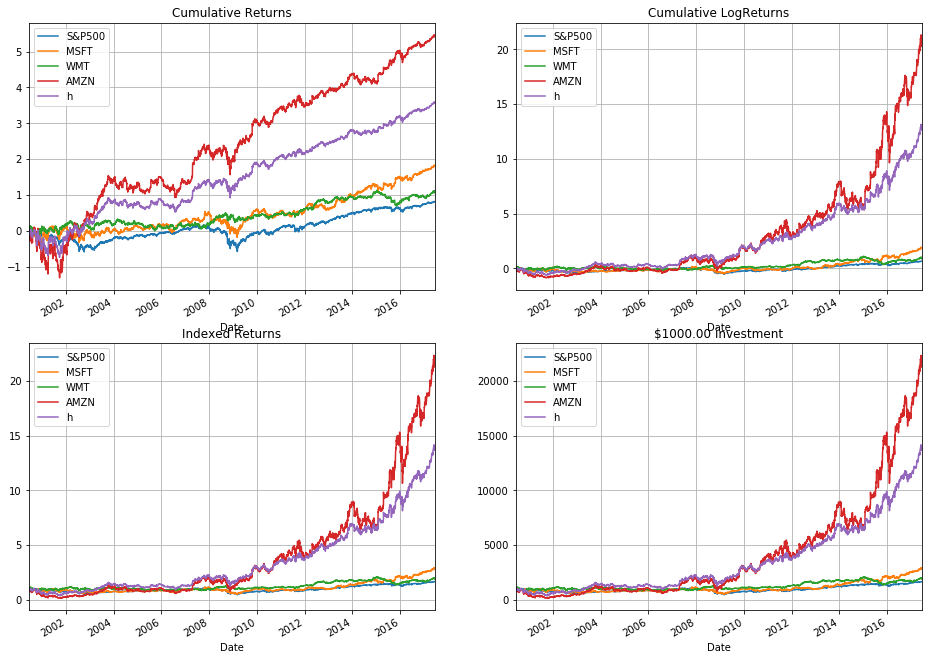

In [6]:
# Plots of returns
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

cum_rets.plot(ax=ax1 ,title='Cumulative Returns',grid=True);
cum_logrets.plot(ax=ax2 ,title='Cumulative LogReturns',grid=True);
indexed_returns.plot(ax=ax3 ,title='Indexed Returns',grid=True);
money_returns.plot(ax=ax4 ,title='$1000.00 investment',grid=True);

In [7]:
pd.set_option('display.precision',4)    
Stats,Daily_Drawdown = Backtest(returns)
Stats


,Avg Returns,Avg Volatility,Sharpe Ratio,Max Drawdown
S&P500,4.8190,19.3439,0.2491,-56.7754
MSFT,10.6193,30.0177,0.3538,-57.9419
WMT,6.2397,22.4447,0.2780,-36.4352
AMZN,32.0574,53.2160,0.6024,-87.0569
h,20.9868,33.5714,0.6251,-64.1102


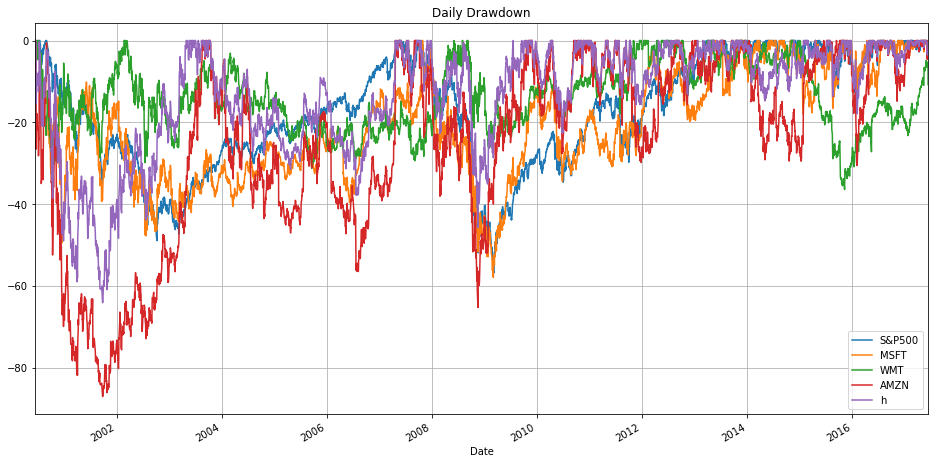

In [8]:
Daily_Drawdown.plot(title='Daily Drawdown',figsize=(16,8),grid=True);